<IPython.core.display.Javascript object>


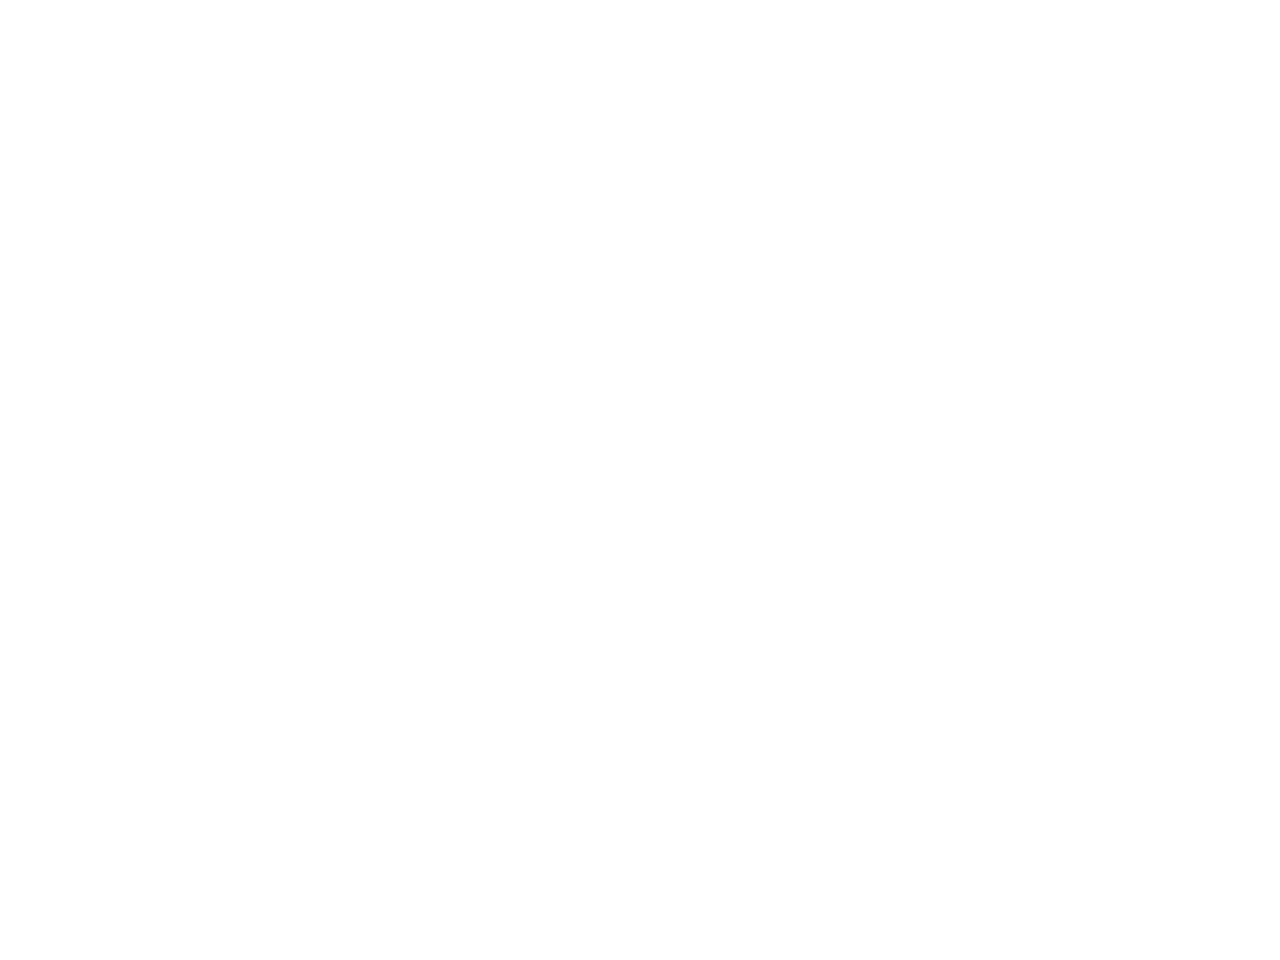

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib notebook


symptoms = ['tos', 'dysphonia', 'tachypnea', 'ausc_resp', 'odynophagia', 'nasal_congestion', 'fatiga', 'headache']
covid_pvals = [x/10 for x in range(1,9)]           #Exemple
cold_pvals = [(x-5)**2/20 for x in range(1,9)]     #Exemple
"""
...
other diseases' pvals
...
"""

x = np.arange(len(symptoms))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, covid_pvals, width, label='Covid', color='skyblue')
rects2 = ax.bar(x + width/2, cold_pvals, width, label='Cold', color='salmon')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('P-value')
ax.set_ylim(0, 1)
ax.set_title('P-values for each disease')
ax.set_xticks(x)
ax.set_xticklabels(symptoms)
ax.legend()

for tick in ax.get_xticklabels():
    tick.set_rotation(55)

def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, stats
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold

################################################################################
import numpy as np
import pandas as pd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.transforms import (
    Bbox, TransformedBbox, blended_transform_factory)
from mpl_toolkits.axes_grid1.inset_locator import (
    BboxPatch, BboxConnector, BboxConnectorPatch)
%matplotlib notebook

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error


data = pd.read_csv("clean_data.csv")
diagnosis = pd.read_csv("diagnosis_data.csv")
dict1 = {}


def test_hipotesis(column, data):
    clean_list1, clean_list2 = [], []
    a, b = np.array(data[column]), np.array(diagnosis['final_diagnosis_code'])
    for i in range(len(a)):
        if not np.isnan(a[i]) and not np.isnan(b[i]):
            clean_list1.append(a[i])
            clean_list2.append(b[i])
    if not clean_list1 or np.all(clean_list1 == clean_list1[0]) or np.all(clean_list2 == clean_list2[0]): # casos en el cas no hi ha cap valor numeric o es te una array uniforme
        return False
    stat, pval = stats.pearsonr(clean_list1, clean_list2)
    
    dict1[column] = 1 - pval
    
    return pval < 0.05

impactful_variables = []
for column in data.columns:
    if (data.dtypes[column] in ['float64', 'int64']):
        if (test_hipotesis(column, data)):
            impactful_variables.append(column)

<IPython.core.display.Javascript object>


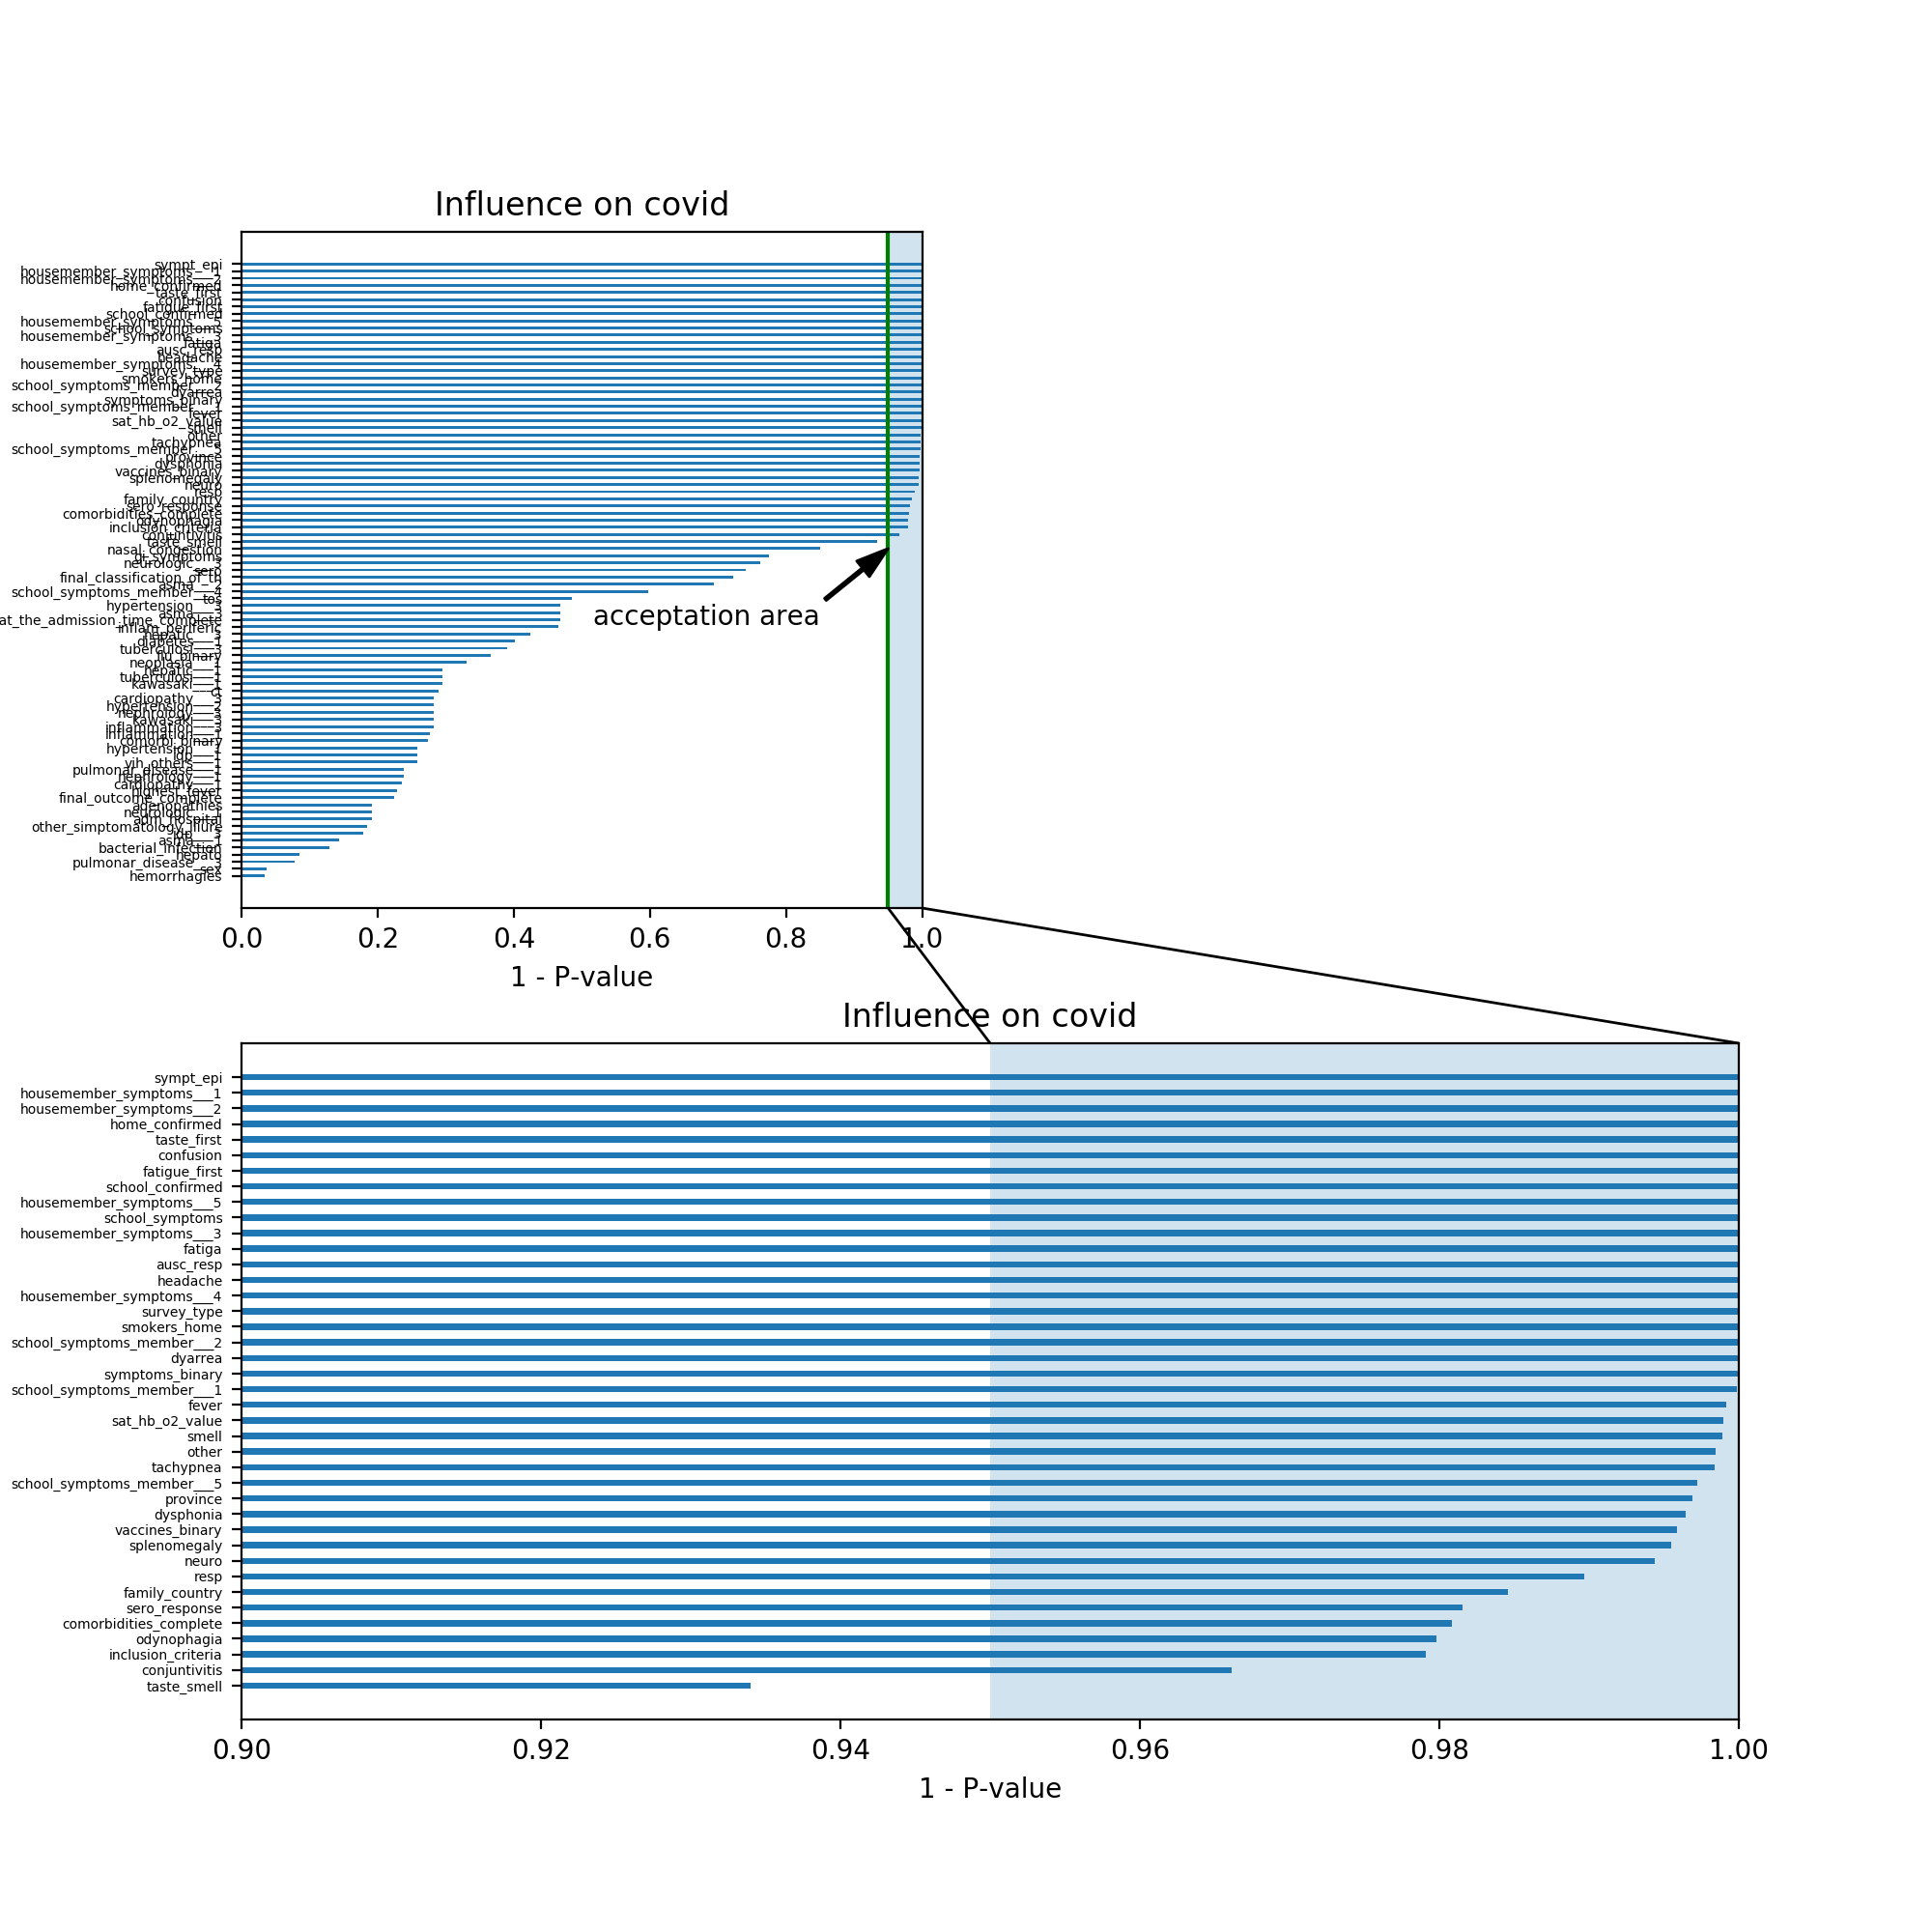

In [3]:
plt.rcdefaults()
plt.figure(figsize=(10,10))
ax = plt.subplot(221)
ax2 = plt.subplot(212)

sorted_keys = sorted(dict1, key=dict1.get, reverse=True)  # [1, 3, 2]
dict2 = {w : dict1[w] for w in sorted_keys}

y_pos = np.arange(len(sorted_keys))
pvals = [dict2[var] for var in dict2.keys()]

ax.barh(y_pos, pvals, 0.4, align='center')
ax.set_xlim(0,1)
ax.set_yticks(y_pos)
ax.set_yticklabels(sorted_keys,fontsize=5,wrap=False)
ax.axvline(x=0.95, c='g')
# ax.axvspan(0.95, 1., color='palegreen', alpha=1,zorder=0)

ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('1 - P-value')
ax.set_title('Influence on covid')

ax.annotate('acceptation area', (0.95, 40),
            xytext=(0.85, 0.45), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', width=1, headwidth=7.5),
            fontsize=10,
            horizontalalignment='right', verticalalignment='top')

def connect_bbox(bbox1, bbox2,
                 loc1a, loc2a, loc1b, loc2b,
                 prop_lines, prop_patches=None):
    if prop_patches is None:
        prop_patches = {
            **prop_lines,
            "alpha": prop_lines.get("alpha", 1) * 0.2,
        }

    c1 = BboxConnector(bbox1, bbox2, loc1=loc1a, loc2=loc2a, **prop_lines)
    c1.set_clip_on(False)
    c2 = BboxConnector(bbox1, bbox2, loc1=loc1b, loc2=loc2b, **prop_lines)
    c2.set_clip_on(False)

    bbox_patch1 = BboxPatch(bbox1, **prop_patches)
    bbox_patch2 = BboxPatch(bbox2, **prop_patches)

    p = BboxConnectorPatch(bbox1, bbox2,
                           # loc1a=3, loc2a=2, loc1b=4, loc2b=1,
                           loc1a=loc1a, loc2a=loc2a, loc1b=loc1b, loc2b=loc2b,
                           **prop_patches)
    p.set_clip_on(False)

    return c1, c2, bbox_patch1, bbox_patch2, p

def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

ax2.set_xlim(0.9, 1)
ax2.barh(y_pos[:40], pvals[:40], 0.4, align='center')
ax2.set_yticks(y_pos[:40])
ax2.set_yticklabels(sorted_keys[:40],fontsize=5,wrap=False)

ax2.invert_yaxis()  # labels read top-to-bottom
ax2.set_xlabel('1 - P-value')
ax2.set_title('Influence on covid')

zoom_effect01(ax, ax2, 0.95, 1)

plt.show()

<IPython.core.display.Javascript object>


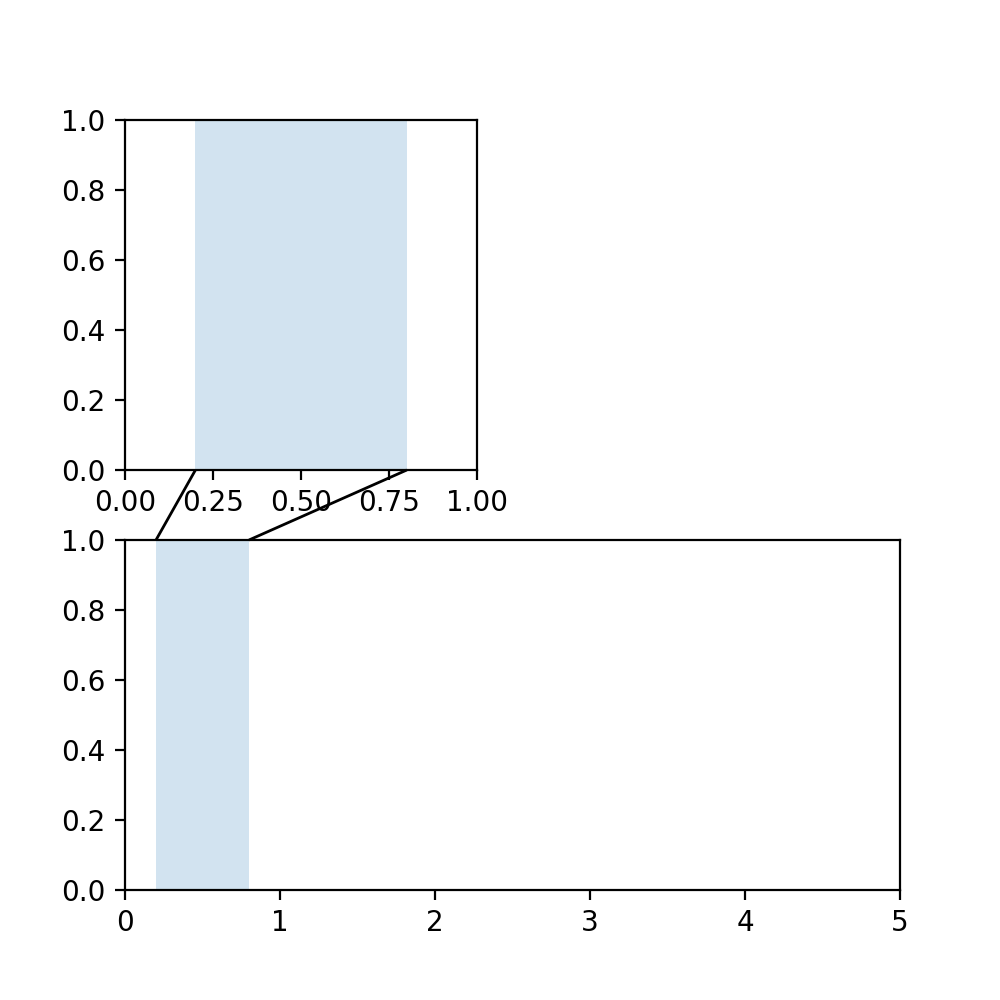

(<mpl_toolkits.axes_grid1.inset_locator.BboxConnector at 0x7ff4bd0f0850>,
 <mpl_toolkits.axes_grid1.inset_locator.BboxConnectorPatch at 0x7ff4bd0f0c50>)

In [4]:
def zoom_effect01(ax1, ax2, xmin, xmax, **kwargs):
    """
    Connect *ax1* and *ax2*. The *xmin*-to-*xmax* range in both axes will
    be marked.

    Parameters
    ----------
    ax1
        The main axes.
    ax2
        The zoomed axes.
    xmin, xmax
        The limits of the colored area in both plot axes.
    **kwargs
        Arguments passed to the patch constructor.
    """

    trans1 = blended_transform_factory(ax1.transData, ax1.transAxes)
    trans2 = blended_transform_factory(ax2.transData, ax2.transAxes)

    bbox = Bbox.from_extents(xmin, 0, xmax, 1)

    mybbox1 = TransformedBbox(bbox, trans1)
    mybbox2 = TransformedBbox(bbox, trans2)

    prop_patches = {**kwargs, "ec": "none", "alpha": 0.2}

    c1, c2, bbox_patch1, bbox_patch2, p = connect_bbox(
        mybbox1, mybbox2,
        loc1a=3, loc2a=2, loc1b=4, loc2b=1,
        prop_lines=kwargs, prop_patches=prop_patches)

    ax1.add_patch(bbox_patch1)
    ax2.add_patch(bbox_patch2)
    ax2.add_patch(c1)
    ax2.add_patch(c2)
    ax2.add_patch(p)

    return c1, c2, bbox_patch1, bbox_patch2, p

plt.figure(figsize=(5, 5))
ax1 = plt.subplot(221)
ax2 = plt.subplot(212)
ax2.set_xlim(0, 1)
ax2.set_xlim(0, 5)
zoom_effect01(ax1, ax2, 0.2, 0.8)